# Machine Learning Approaches to Better Utilize HM450K Data in Cancer Analysis
## Aim 1: Utilize Machine Learning to Determine Tumor State
### Approach 1.2: If we reduce the HM450K to HM27 data, does that affect our performance and ability to use SHAP?

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import json
import multiprocessing
import os
import sys
import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import shap
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import (ConfusionMatrixDisplay, PrecisionRecallDisplay,
                             RocCurveDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath(".."))

from utils import (RANDOM_STATE, get_tumor_normal_ml_data,
                   stratified_train_test_split)

In [7]:
ip = get_ipython()
path = None
if "__vsc_ipynb_file__" in ip.user_ns:
    path = ip.user_ns["__vsc_ipynb_file__"]

currfile = os.path.splitext(os.path.basename(path))[0]
currfile

'02_dim_red_prediction_hm27'

#### Load and prep the data

The first step in this analysis is to load the data in and prep it. To do this we remove all features with less than 80% of the samples having data. This ensures that after our train-test split, there will be some data for all used features prior to imputing.

In [8]:
X, y = get_tumor_normal_ml_data(hm_27=True)

In [9]:
X_filtered = X.loc[:, X.isna().mean() < 0.8]
print("Dropped {N} columns with all NaN values".format(N=X.shape[1] - X_filtered.shape[1]))

Dropped 0 columns with all NaN values


In [10]:
X_filtered

ENTITY_STABLE_ID,cg00000292,cg00003994,cg00005847,cg00007981,cg00008493,cg00008713,cg00009407,cg00011459,cg00012199,cg00012386,...,cg27651218,cg27652350,cg27653134,cg27654142,cg27655905,cg27657283,cg27661264,cg27662379,cg27662877,cg27665659
TCGA-2A-A8VL-01,0.743283,0.072272,0.615289,0.024384,0.928817,0.055353,0.031280,0.946620,0.032639,0.035285,...,0.913216,0.243026,0.498315,0.040869,0.029888,0.022910,0.142701,0.045062,0.036641,0.063258
TCGA-2A-A8VO-01,0.630143,0.133472,0.566151,0.023196,0.938485,0.052331,0.024999,0.939624,0.026985,0.038910,...,0.941886,0.101337,0.499453,0.036238,0.039788,0.036157,0.335054,0.036540,0.027097,0.036544
TCGA-2A-A8VT-01,0.633692,0.268712,0.728255,0.024627,0.922617,0.032642,0.024788,0.829843,0.031472,0.028074,...,0.913852,0.261440,0.677838,0.055831,0.026104,0.027175,0.163027,0.046415,0.031748,0.042414
TCGA-2A-A8VV-01,0.643800,0.079160,0.826008,0.022784,0.916749,0.062634,0.024674,0.932249,0.039377,0.041003,...,0.946643,0.093389,0.571192,0.038841,0.034923,0.028802,0.122760,0.056377,0.029467,0.034029
TCGA-2A-A8VX-01,0.796107,0.255795,0.836811,0.025117,0.928310,0.047323,0.034034,0.908861,0.040282,0.049794,...,0.933783,0.107742,0.549409,0.050328,0.043812,0.038704,0.112784,0.052000,0.037906,0.039406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-E9-A1RD-11A,0.070000,0.130000,0.040000,0.060000,0.010000,0.030000,0.040000,0.030000,0.010000,0.050000,...,0.360000,NaN,0.340000,0.460000,0.340000,0.230000,0.320000,0.260000,NaN,NaN
TCGA-BH-A1FR-11B,0.070000,0.160000,0.030000,0.070000,0.010000,0.010000,0.050000,0.020000,0.010000,0.030000,...,0.430000,NaN,0.320000,0.440000,0.260000,0.290000,0.290000,0.310000,NaN,NaN
TCGA-E9-A1RC-11A,0.150000,0.140000,0.060000,0.120000,0.010000,0.020000,0.080000,0.070000,0.020000,0.070000,...,0.330000,NaN,0.320000,0.400000,0.320000,0.260000,0.350000,0.220000,NaN,NaN
TCGA-BH-A1F8-11B,0.080000,0.130000,0.020000,0.090000,0.010000,0.020000,0.090000,0.030000,0.010000,0.030000,...,0.380000,NaN,0.370000,0.460000,0.350000,0.370000,0.350000,0.250000,NaN,NaN


In [11]:
X_filtered.shape, y.shape

((2772, 22601), (2772,))

In [12]:
X_train, X_test, y_train, y_test = stratified_train_test_split(X_filtered, y)

In [13]:
X_train, X_test, y_train, y_test = (
    X_train.to_numpy(),
    X_test.to_numpy(),
    y_train.to_numpy(),
    y_test.to_numpy(),
)

In [14]:
# num_cpus = multiprocessing.cpu_count() // 2
num_cpus = 10

#### Hyperparameter tuning

To find the best hyperparameters for our pipeline, we will use RandomizedSearchCV. The parameters we are tuning are:

For the LocallyLinearEmbedding model:
- n_components
- n_neighbors
- tol
- max_iter
- hessian_tol

For the LogisticRegression model:
- tol
- l1_ratio
- max_iter


In [15]:
# If file best_params.json exists, load it
try:
    with open(f"{currfile}.best_params.json", "r") as file:
        best_params = json.load(file)
    results = pd.read_csv(f"{currfile}.hyperparmeter_tuning_results.csv")

except FileNotFoundError:
    best_params = None
    param_grid = {
        "classifier__tol": np.logspace(-6, -3, 10),
        "classifier__l1_ratio": np.linspace(0, 1, 20),
        "classifier__C": np.arange(2, 26, 5),
        "classifier__max_iter": np.arange(75, 151, 5),
        "embedder__n_components": np.arange(500, 2000, 250),
        "embedder__n_neighbors": np.arange(2, 100, 5),
        "embedder__tol": np.logspace(-6, -3, 10),
        "embedder__max_iter": np.arange(75, 151, 5),
        "embedder__hessian_tol": np.logspace(-6, -3, 10),
    }

    pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="mean")),
            ("embedder", LocallyLinearEmbedding(random_state=RANDOM_STATE, n_jobs=num_cpus, neighbors_algorithm="kd_tree")),
            (
                "classifier",
                LogisticRegression(
                    random_state=RANDOM_STATE,
                    n_jobs=num_cpus,
                    penalty="elasticnet",
                    solver="saga",
                    class_weight="balanced",
                ),
            ),
        ]
    )

    grid_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        cv=5,
        n_jobs=num_cpus,
        n_iter=20,
        random_state=RANDOM_STATE,
        scoring="precision",
    )

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    results = pd.DataFrame(grid_search.cv_results_)

    param_details = pd.json_normalize(results["params"])
    results = pd.concat([results, param_details], axis=1)

    results.to_csv(f"{currfile}.hyperparmeter_tuning_results.csv")
    best_params_serializable = {
        k: int(v) if isinstance(v, np.integer) else v for k, v in best_params.items()
    }

    with open(f"{currfile}.best_params.json", "w") as file:
        json.dump(best_params_serializable, file)

In [16]:
results

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_embedder__tol,param_embedder__n_neighbors,param_embedder__n_components,param_embedder__max_iter,param_embedder__hessian_tol,...,rank_test_score,embedder__tol,embedder__n_neighbors,embedder__n_components,embedder__max_iter,embedder__hessian_tol,classifier__tol,classifier__max_iter,classifier__l1_ratio,classifier__C
0,0,61.533080,2.516872,11.326279,1.048156,0.000005,72,750,90,0.000010,...,16,0.000005,72,750,90,0.000010,0.000464,100,0.631579,12
1,1,51.948256,6.272416,5.389934,0.617349,0.000022,7,1500,125,0.000010,...,13,0.000022,7,1500,125,0.000010,0.000010,125,0.263158,7
2,2,33.801613,3.540360,5.260033,0.422683,0.000001,12,750,125,0.000215,...,1,0.000001,12,750,125,0.000215,0.000002,130,0.157895,22
3,3,56.373630,2.833574,9.694811,0.946559,0.000022,62,1750,80,0.000010,...,15,0.000022,62,1750,80,0.000010,0.000002,110,0.157895,22
4,4,52.656914,2.812289,12.625431,2.423826,0.000001,77,1000,135,0.000001,...,17,0.000001,77,1000,135,0.000001,0.000001,140,0.052632,7
5,5,56.420105,1.325841,8.990189,0.781140,0.000010,57,1250,80,0.000002,...,19,0.000010,57,1250,80,0.000002,0.000010,100,0.105263,17
6,6,49.761919,4.745086,12.374081,1.300163,0.000464,87,500,105,0.000046,...,9,0.000464,87,500,105,0.000046,0.001000,135,0.052632,7
7,7,34.898386,2.059976,7.203868,1.087727,0.000022,7,750,75,0.000022,...,6,0.000022,7,750,75,0.000022,0.000100,150,0.684211,2
8,8,36.030415,3.178181,10.095297,2.246486,0.000001,7,1000,80,0.000010,...,5,0.000001,7,1000,80,0.000010,0.001000,80,0.421053,2
9,9,63.662106,2.439257,11.132988,0.465234,0.000022,77,1500,90,0.000005,...,4,0.000022,77,1500,90,0.000005,0.000010,90,0.210526,17


In [17]:
print("Best parameters:")
pprint.pprint(best_params)

Best parameters:
{'classifier__C': 22,
 'classifier__l1_ratio': 0.15789473684210525,
 'classifier__max_iter': 130,
 'classifier__tol': 2.1544346900318822e-06,
 'embedder__hessian_tol': 0.00021544346900318823,
 'embedder__max_iter': 125,
 'embedder__n_components': 750,
 'embedder__n_neighbors': 12,
 'embedder__tol': 1e-06}


#### Train classification pipeline with best parameters

After finding the best hyperparameters using RandomSearchCV, the next step is to train the final pipeline with those parameters

In [18]:
embedder_args = {k.split("__")[1]: v for k, v in best_params.items() if "embedder" in k}
classifier_args = {k.split("__")[1]: v for k, v in best_params.items() if "classifier" in k}

classification_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        (
            "embedder",
            LocallyLinearEmbedding(random_state=RANDOM_STATE, n_jobs=num_cpus, neighbors_algorithm="kd_tree", **embedder_args),
        ),
        (
            "classifier",
            LogisticRegression(
                random_state=RANDOM_STATE,
                n_jobs=num_cpus,
                penalty="elasticnet",
                solver="saga",
                class_weight="balanced",
                **classifier_args,
            ),
        ),
    ]
)

classification_pipeline.fit(X_train, y_train)

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_methylation_project/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('imputer', SimpleImputer()),
                ('embedder',
                 LocallyLinearEmbedding(hessian_tol=0.00021544346900318823,
                                        max_iter=125, n_components=750,
                                        n_jobs=10, n_neighbors=12,
                                        neighbors_algorithm='kd_tree',
                                        random_state=42)),
                ('classifier',
                 LogisticRegression(C=22, class_weight='balanced',
                                    l1_ratio=0.15789473684210525, max_iter=130,
                                    n_jobs=10, penalty='elasticnet',
                                    random_state=42, solver='saga',
                                    tol=2.1544346900318822e-06))])

In [19]:
font_size = 14

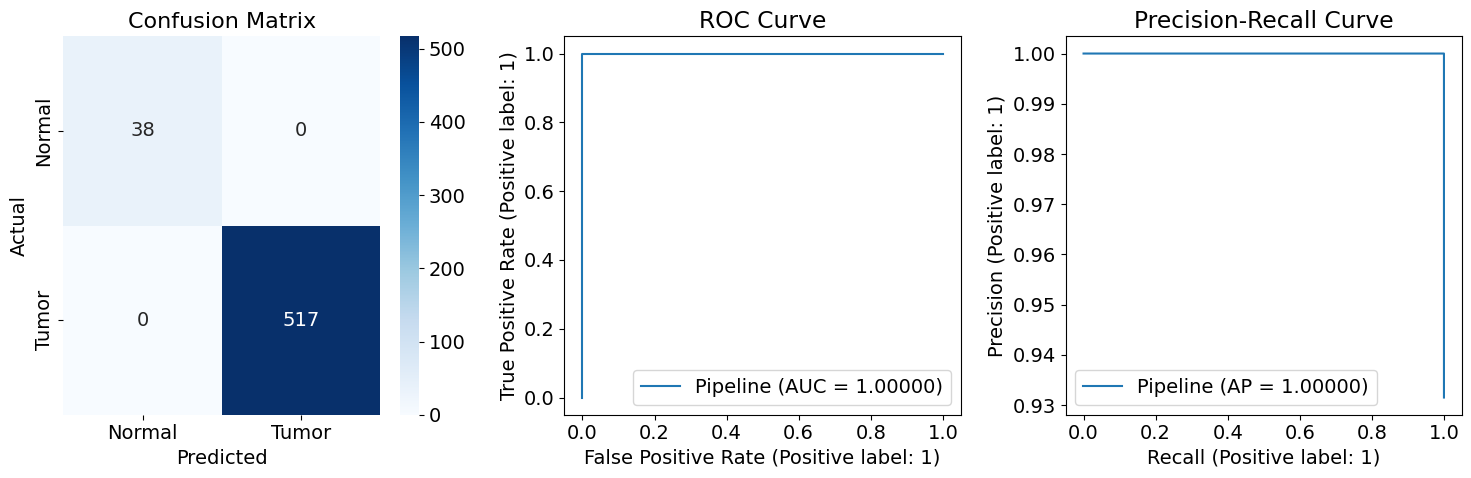

In [20]:
plt.rcParams.update({"font.size": font_size})

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# ConfusionMatrixDisplay.from_estimator(
#     classification_pipeline,
#     X_test,
#     y_test,
#     ax=ax[0],
#     display_labels=["Normal", "Tumor"],
# )
# ax[0].set_title("Confusion Matrix")
cm = confusion_matrix(y_test, classification_pipeline.predict(X_test))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Tumor"],
    yticklabels=["Normal", "Tumor"],
    ax=ax[0],
    annot_kws={"fontsize": font_size},
)
ax[0].set_xlabel("Predicted", fontsize=font_size)
ax[0].set_ylabel("Actual", fontsize=font_size)
ax[0].set_title("Confusion Matrix", fontsize=font_size + 2)
ax[0].tick_params(axis="both", which="major", labelsize=font_size)

roc_display = RocCurveDisplay.from_estimator(
    classification_pipeline,
    X_test,
    y_test,
    ax=ax[1],
)
ax[1].set_title("ROC Curve")
roc_display.line_.set_label(f"Pipeline (AUC = {roc_display.roc_auc:.5f})")
ax[1].legend()

pr_display = PrecisionRecallDisplay.from_estimator(
    classification_pipeline,
    X_test,
    y_test,
    ax=ax[2],
)
ax[2].set_title("Precision-Recall Curve")
pr_display.line_.set_label(f"Pipeline (AP = {pr_display.average_precision:.5f})")
ax[2].legend()

plt.tight_layout()
plt.show()

In [21]:
report = classification_report(y_test, classification_pipeline.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00       517

    accuracy                           1.00       555
   macro avg       1.00      1.00      1.00       555
weighted avg       1.00      1.00      1.00       555



#### Explainable AI analysis

To interpret our model, we will implement SHAP to determine the features of most importance. We will attempt to implement it in 3 ways

1. Explain the Classifier alone with the reduced feature set from LLE
   - This will allow us to test SHAP on out model, for LLE embeddings, this is not going to add much explainability as there is not at way to reverse the embeddings
2. Explain the whole pipeline
   - This is the ideal solution to determine what features are the most important, but due to the high dimensionality of our data, may not be possible   
3. Utilize SKLearn permutation_importance
   - This implementation would use less memory and therefore be a possible way to add explainability, but also may take too much time 

In [ ]:
shap.initjs()

In [ ]:
feature_names = X_filtered.columns
len(feature_names)

22601

In [ ]:
def model_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=feature_names)
    return classification_pipeline.predict(data_asframe)

In [ ]:
transformed_feature_names = classification_pipeline[:-1].get_feature_names_out(
    feature_names
)
transformed_feature_names

array(['locallylinearembedding0', 'locallylinearembedding1',
       'locallylinearembedding2', 'locallylinearembedding3',
       'locallylinearembedding4', 'locallylinearembedding5',
       'locallylinearembedding6', 'locallylinearembedding7',
       'locallylinearembedding8', 'locallylinearembedding9',
       'locallylinearembedding10', 'locallylinearembedding11',
       'locallylinearembedding12', 'locallylinearembedding13',
       'locallylinearembedding14', 'locallylinearembedding15',
       'locallylinearembedding16', 'locallylinearembedding17',
       'locallylinearembedding18', 'locallylinearembedding19',
       'locallylinearembedding20', 'locallylinearembedding21',
       'locallylinearembedding22', 'locallylinearembedding23',
       'locallylinearembedding24', 'locallylinearembedding25',
       'locallylinearembedding26', 'locallylinearembedding27',
       'locallylinearembedding28', 'locallylinearembedding29',
       'locallylinearembedding30', 'locallylinearembedding31',
  

In [ ]:
explainer = shap.LinearExplainer(
    classification_pipeline.named_steps["classifier"],
    classification_pipeline[:-1].transform(X_test),
    feature_names=transformed_feature_names,
)

In [ ]:
explanations = explainer(classification_pipeline[:-1].transform(X_test))

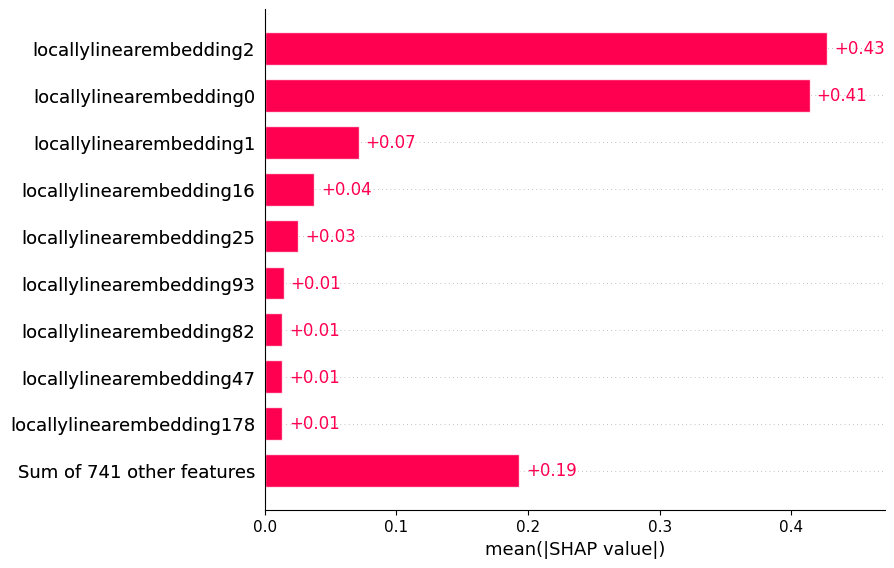

In [ ]:
shap.plots.bar(explanations)

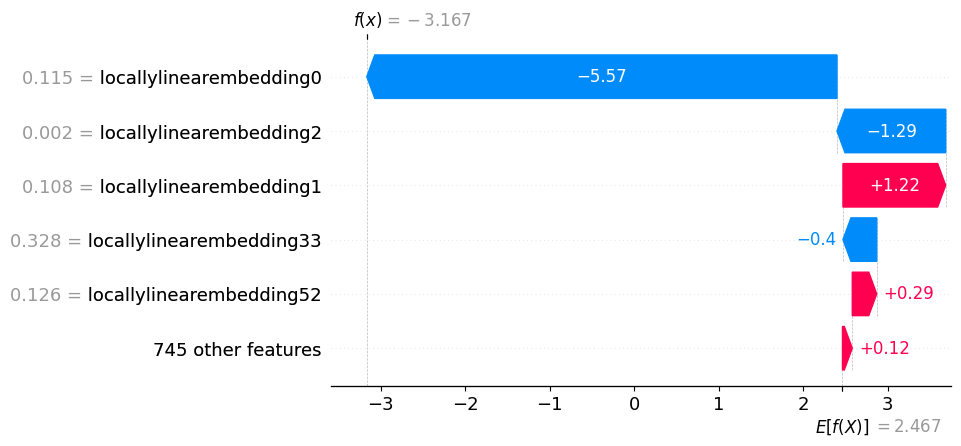

In [ ]:
shap.plots.waterfall(explanations[0], max_display=6)

In [ ]:
explainer = shap.KernelExplainer(
    classification_pipeline.predict,
    shap.kmeans(X_test, 10),
    feature_names=feature_names,
)

In [ ]:
explanations = explainer(shap.sample(X_test, 3, random_state=RANDOM_STATE))

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
explanations[0]

.values =
array([0., 0., 0., ..., 0., 0., 0.])

.base_values =
0.9315315315315316

.data =
array([0.84232541, 0.16445716, 0.52020726, ..., 0.03965723, 0.27448692,
       0.10786752])

In [ ]:
feature_names

Index(['cg00000292', 'cg00003994', 'cg00005847', 'cg00007981', 'cg00008493',
       'cg00008713', 'cg00009407', 'cg00011459', 'cg00012199', 'cg00012386',
       ...
       'cg27651218', 'cg27652350', 'cg27653134', 'cg27654142', 'cg27655905',
       'cg27657283', 'cg27661264', 'cg27662379', 'cg27662877', 'cg27665659'],
      dtype='object', name='ENTITY_STABLE_ID', length=22601)

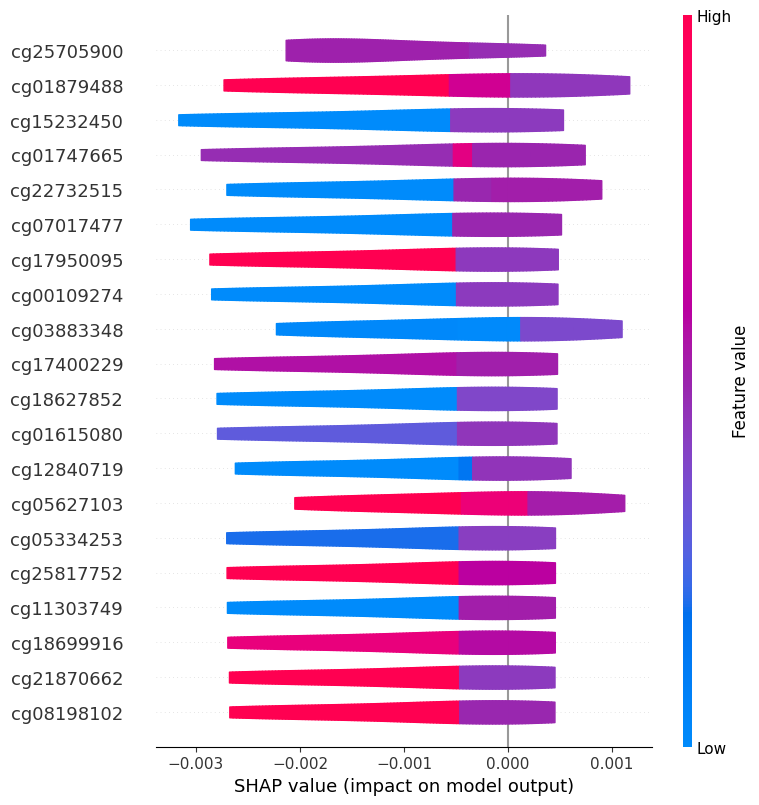

In [ ]:
shap.plots.violin(explanations)

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    classification_pipeline, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE, n_jobs=20
)

# Map importance scores to original feature names
feature_importances = dict(zip(feature_names, result.importances_mean))